# Explainer notebook
## Social Graphs and Interactions - 02805

This notebook contains the analyses that were used in the creation of the website. The notebook will be split into five parts, as specified in the project assignment as well as an introduction and will contain the following.

Table of contents.

* Introduction
* Motivation
* Basic statistics
* Tools, theory and analysis
    - Comparison to random networks
    - Wordclouds and TF-IDF
    - Communities and sentiment analysis
* Discussion
* Contributions


### Introduction
Welcome to the vast world of the Witcher. The Polish hit fantasy novella has been adapted into extremely popular games as well as a Netflix hit series and both the fanbase and the amount of lore is huge. The goal of the webpage is to inform and educate fans of the intricate relationships that span the continent, from the cold northern kingdom Redania to the warm and bountiful lands of Toussaint towards the Nilfgardian Empire to the south. Who are central to the story, how does the political factions interact and how is the lines between good and evil drawn? 

### Motivation
#### Data
The dataset consists of all characters present in the three Witcher games scraped from the Witcher Wiki - https://witcher.fandom.com/wiki/Witcher_Wiki.  
The main reason for choosing the games is that they are a very close adaptation of the books and thus almost all characters are present in the games. As the tv show is new and only has one season as of November 2021, the characters present in the series are not in themselves representative of the universe and furthermore these are covered in the games. 


#### Why the Witcher?
As mentioned in the introduction the Witcher universe has a well established, long running community of fans. It is a large universe and contains many great stories and characters. The desire to inform new fans of the series comes from loving the series, but also seeing great potential in the universe as there are a large number of characters, political factions and intrigue, which will make both network and text analysis interesting.  


#### The end user experience 
The goal is to provide a highly interactive website which informs and educates those who love the Witcher universe as much as the authors. One should be able to play with, and explore the network as well as getting great insights into the intermingling of characters. 



### Basic statistics

#### Preprocessing of data
In the following section the data cleaning choices will be detailed as well as the first statistics that were done on the data in order to create a better understanding. The data was loaded through the Wiki API and the character names were stored in a .csv. Using that .csv each of the pages were extracted from the Wiki, where page titles corresponds to character names. This was then saved as individual .txt files for each character from which data preprocessing could begin. The initial load can be found below. 

In [36]:
#General
import pandas as pd
import re
import urllib.request
import json
import networkx as nx
import matplotlib.pyplot as plt
import requests
import os.path
import numpy as np
import seaborn as sns
import pickle
import collections
import powerlaw as pw

#Wordclouds
from nltk.corpus import PlaintextCorpusReader
import nltk
from nltk.probability import FreqDist
import math
from wordcloud import WordCloud, ImageColorGenerator 
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude

#Communities
import community as community_louvain
import matplotlib.cm as cm
from collections import Counter
from fa2 import ForceAtlas2
import plotly.graph_objects as go
import copy

#LDA
import gensim.corpora as corpora
from gensim.models import TfidfModel
from pprint import pprint
import gensim
from nltk.corpus import stopwords
nltk.download('stopwords')
from os import listdir
from os.path import isfile, join

#Sentiment
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Witcher 1 
S = requests.Session()
URL = "https://witcher.fandom.com/api.php"
PARAMS = {
    "action": "query",
    "format": "json",
    "list": "categorymembers",
    "cmtitle": "Category:The_Witcher_characters",
    "cmlimit": 500,
}
R = S.get(url=URL, params=PARAMS)
w1 = R.json()

# Witcher 2 
S = requests.Session()
URL = "https://witcher.fandom.com/api.php"
PARAMS = {
    "action": "query",
    "format": "json",
    "list": "categorymembers",
    "cmtitle": "Category:The_Witcher_2_characters",
    "cmlimit": 500,
}
R = S.get(url=URL, params=PARAMS)
w2 = R.json()

# Witcher 3 
S = requests.Session()
URL = "https://witcher.fandom.com/api.php"
PARAMS = {
    "action": "query",
    "format": "json",
    "list": "categorymembers",
    "cmtitle": "Category:The_Witcher_3_characters",
    "cmlimit": 500,
}
R = S.get(url=URL, params=PARAMS)
w31 = R.json()

# Witcher 3 
S = requests.Session()
URL = "https://witcher.fandom.com/api.php"
PARAMS = {
    "action": "query",
    "format": "json",
    "list": "categorymembers",
    "cmtitle": "Category:The_Witcher_3_characters",
    "cmlimit": 500,
    "cmcontinue": w31["continue"]["cmcontinue"],
    "continue": w31["continue"]["continue"]
}
R = S.get(url=URL, params=PARAMS)
w32 = R.json()

In [ ]:
df = pd.DataFrame.from_dict(w1["query"]["categorymembers"])
df = pd.concat([df, pd.DataFrame.from_dict(w2["query"]["categorymembers"])], axis=0)
df = pd.concat([df, pd.DataFrame.from_dict(w31["query"]["categorymembers"])], axis=0)
df = pd.concat([df, pd.DataFrame.from_dict(w32["query"]["categorymembers"])], axis=0)
df.reset_index(inplace=True)
df = df[["pageid","title"]]
df = df.drop_duplicates(["pageid", "title"])

In [ ]:
# Remove Category titles
df = df[~df['title'].str.contains("Category")]

In [ ]:
#Saving data with accented é and ï in txt file names
#This catches more info.
baseurl = "https://witcher.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat ="format=json"

for t in df['title']:
    try:
        title_name = t.replace(" ", "_") #Ensure that whitespace -> underscores
        title_string = str(title_name.encode(encoding='UTF-8',errors='strict'))
        title_string = title_string[:-1].replace("b\'", "").replace("\\x", "%").replace("b\"", "")
        title = f"titles={title_string}"
        query = "{}{}&{}&{}&{}".format(baseurl, dataformat, action, content, title)

        response = urllib.request.urlopen(query)
        data = response.read()
        text = data.decode("UTF-8")
        text_json = json.loads(text)
        final_text = text_json["query"]["pages"][list(text_json["query"]["pages"].keys())[0]]["revisions"][0]["slots"]["main"]["*"]
        filename = title_name +'.txt'
        
        savepath = 'data'
        completeName = os.path.join(savepath, filename)
        
        with open(completeName, 'w') as f:
            f.write(final_text)
    except:
        print(t)

In [ ]:
#Save the raw data
df.to_csv("/work/socialgraph-witcher-analysis/data/unclean_characters.csv", index=False)

With the characters in place the next step was to choose some attributes and clean the characters data storing them in a DataFrame for convenience. This is done using several RegEx statements extracting the correct information on the characters. The RegEx that extracts attributes looks the following:

1. `Race\s*=\s*\[\[(.+?)\]\]`
2. `Race\s*=\s*(\w+)`
3. `Gender\s*=\s*(\w+)`
4. `Nationality\s*=\s*\{\{(.+?)\}\}`
5. `Family\s*=\s*\[\[(.+)\]\]`
6. `Profession\s*=\s*\[\[\w+\]\]\<\w+\>\[\[(.+)\|.+\]\]`
7. `Profession\s*=\s*\[\[([^\n\r]*)\]\]`
8. `Profession\s*=\s*\[\[(\w+)\]\]\<\w+\>\[\[(\w+)\]\]`
9. `Profession\s*=\s*\w+\<\w+\>\[\[(\w+)\]\]`
10. `Profession\s*=\s*(\w+)`
11. `Profession\s*=\s*(\w\t+)`
12. `Profession\s*=\s*([^\n\r]*)`

The first and second expression, 1 and 2, matches cases where the first word is Race and an equals (=) sign regardless of the spacing between Race and =, as that is not consistent across articles. Then, 1 matches anything between two sets of square brackets where 2 matches any word not in square brackets. Most instances of Race is between brackets and 2 catches the ones that are not.

Number 3 matches any word coming after Gender, any whitespace combination and a =. The structure for gender does not contain links and is always a single word so everything is caught here.

Number 4 deals with Nationality. Nationality as denoted between curly brackets, {{Nationality}} and everything between two of these is matched.

Then number 5 catches the Family that a character belongs to. This is set between brackets, [[Family]], and is captured as such.

Finally, 6 through 12 deals with Profession. Profession is a bit more complicated to catch since the structure is wildly different from character to character. Some has several entries, with the main profession first, some is enclosed in brackets, some not. Some even have a word and a word enclosed in angle brackets before the actual Profession that is not necessary information. The six final RegEx statements deals with this, though upon inspection of the data further preprocessing is needed. 

Once the (still somewhat raw) atrributes were extracted it was time to clean them up. Especially in Profession, some CSS was caught as well as the Profession itself which had to be removed. In the dataframe holding all characters, the Profession column was looped over and if it contained several entries, these were sorted and special characters were removed. Finally there were a few entries that proved to be hard to clean which were then done manually and inserted into the dataframe. It was then decided that each character should have only one profession to ease later distinction between character groups. This process can be followed in the file `build_graph.ipynb` and below.

In [2]:
# Load the raw data
df_characters = pd.read_csv("/work/socialgraph-witcher-analysis/data/unclean_characters.csv")

# Empty arrays for data
Races = []
Genders = []
Nationalities = []
Families = []
Professions = []

# Clean each character text
for n in df_characters['title']:
    filename = n + '.txt'
    filename = filename.replace(" ", "_")
    savepath = '/work/socialgraph-witcher-analysis/notebooks/data'
    completeName = os.path.join(savepath, filename)

    with open(completeName, "r") as f:
        text = f.read()

        matchRace = re.findall(r'Race\s*=\s*\[\[(.+?)\]\]', text, re.IGNORECASE) + \
                    re.findall(r'Race\s*=\s*(\w+)', text, re.IGNORECASE) 

        matchGender = re.findall(r'Gender\s*=\s*(\w+)', text, re.IGNORECASE) 

        matchNatio = re.findall(r'Nationality\s*=\s*\{\{(.+?)\}\}', text, re.IGNORECASE) 

        matchFam = re.findall(r'Family\s*=\s*\[\[(.+)\]\]', text, re.IGNORECASE)

        matchProf = re.findall(r'Profession\s*=\s*\[\[\w+\]\]\<\w+\>\[\[(.+)\|.+\]\]', text, re.IGNORECASE) + \
                    re.findall(r'Profession\s*=\s*\[\[([^\n\r]*)\]\]', text, re.IGNORECASE) + \
                    re.findall(r'Profession\s*=\s*\[\[(\w+)\]\]\<\w+\>\[\[(\w+)\]\]', text, re.IGNORECASE) + \
                    re.findall(r'Profession\s*=\s*\w+\<\w+\>\[\[(\w+)\]\]', text, re.IGNORECASE) + \
                    re.findall(r'Profession\s*=\s*(\w+)', text, re.IGNORECASE) + \
                    re.findall(r'Profession\s*=\s*(\w\t+)', text, re.IGNORECASE)  + \
                    re.findall(r'Profession\s*=\s*([^\n\r]*)', text, re.IGNORECASE)
        
    Races.append(matchRace)
    Genders.append(matchGender)
    Nationalities.append(matchNatio)
    Families.append(matchFam)
    Professions.append(matchProf)

df = df_characters
df['Race'] = Races
df['Gender'] = Genders
df['Nationality'] = Nationalities
df['Family'] = Families
df['Profession'] = Professions

In [3]:
# Show data
df.head()

,pageid,title,Race,Gender,Nationality,Family,Profession
0,8046,Innkeeper,[],[],[],[],[]
1,5069,The Witcher journal character entries,[],[],[],[],[]
2,2478,Abigail,[Human],[Female],[Temerian],[],"[Witch, [[Witch]]]"
3,53882,Adalbert (soldier),[Human],[Male],[Temerian],[],"[Soldier, [[Soldier]]]"
4,2210,Adam (Murky Waters),[Human],[Male],[Temerian],[],"[Poet, Poet]"


In [ ]:
# Function for cleaning the professions
def clean_profession(profession_list):
    if len(profession_list) == 0:
        cleaned_profession = "No Profession"

    elif len(profession_list) == 1:
       cleaned_profession = profession_list[0]

    elif len(profession_list) == 2:

        if profession_list[0] in profession_list[1]:
            profession = profession_list[1]
            if "[" in profession:
                cleaned_profession = re.findall('\[\[([\w\W]+)\]\]', profession)[0]
            elif "{" in profession:
                cleaned_profession = re.sub(r'\s*\{\{.+\}\}', '', profession)
            else:
                cleaned_profession = profession
        else:
            cleaned_profession = profession_list

    else:
        cleaned_profession = profession_list


    return cleaned_profession

In [ ]:
# Apply the clean professions
df["Profession_Clean"] = df["Profession"].apply(lambda x: clean_profession(x))

In [ ]:
# Add No data fields
df["Race"] = df["Race"].apply(lambda x: "No Race" if len(x)==0 else x[0])
df["Gender"] = df["Gender"].apply(lambda x: "No Gender" if len(x)==0 else x[0])
df["Nationality"] = df["Nationality"].apply(lambda x: "No Nationality" if len(x)==0 else x[0])
df["Family"] = df["Family"].apply(lambda x: "No Family" if len(x)==0 else x[0])

#Make Professions_Clean into Strings for merging
df["Profession_Clean"] = df["Profession_Clean"].apply(lambda x: str(x))

In [ ]:
# Save clean professions
df_professions = pd.read_csv("/work/socialgraph-witcher-analysis/data/cleaned_professions.csv")

In [ ]:
# Merge the data
df_merged = df.merge(df_professions, how='left', left_on="Profession_Clean", right_on="original")
df_merged["Profession"] = df_merged["cleaned"]
df_merged = df_merged.drop(["Profession_Clean", "original", "cleaned"], axis=1)
df_merged.head()

In [ ]:
# Save finalized data
df_merged.to_csv('/work/socialgraph-witcher-analysis/data/cleaned_characters_attr.csv')

In [4]:
df_merged

,Unnamed: 0,pageid,title,Race,Gender,Nationality,Family,Profession
0,0,8046,Innkeeper,No Race,No Gender,No Nationality,No Family,No Profession
1,1,5069,The Witcher journal character entries,No Race,No Gender,No Nationality,No Family,No Profession
2,2,2478,Abigail,Human,Female,Temerian,No Family,Witch
3,3,53882,Adalbert (soldier),Human,Male,Temerian,No Family,Soldier
4,4,2210,Adam (Murky Waters),Human,Male,Temerian,No Family,Poet
...,...,...,...,...,...,...,...,...
831,831,35362,Yoana,Human,Female,Skelliger,Clan Tordarroch,Armorer
832,832,51581,Yolar,Human,Male,Skelliger,No Family,Druid
833,833,43932,Yontek,Human,Male,Temerian,No Family,No Profession
834,834,76242,Yorg,Human,Male,Skelliger,No Family,No Profession


#### Network statistics
In order to understand the network better, the following section contains basic statistics on the network. First, the network is put together using the dataframe from above with names and attributes.


In [ ]:
import collections
import powerlaw as pw

In [ ]:
# Create graph and 
WG = nx.DiGraph()
for row in range(df_characters.shape[0]):
    ra = df_merged['Race'][row]
    ge = df_merged['Gender'][row]
    na = df_merged['Nationality'][row]
    fa = df_merged['Family'][row]
    pr = df_merged['Profession'][row]
    WG.add_node(df_characters['title'][row], Race = ra, Gender = ge, Nationality = na, Family = fa, Profession = pr)

In the cell above all nodes were added to a directed graph object. Below the nodes are added by opening each character article and searching through it with RegEx in order to find the links to other characters. These links can take different forms but all are within brackets with varying sorrounding chars. Some have both the character name and their nickname where the part of interest is their actual name. Some names have apostrophes and some have a clarification added after their name in parenthesis e.g. `Princess (Goat)` which denotes the character Princess who happens to be a Goat. This is of course vital information so that needs to be captured along the name. This can all be seen in the four RegEx statements in the cell below. With the matches defined, these are held against the list of characters to ensure that there is something to link to and if the names match they are added to a list of links. Finally these are restructured into a edgelist with the structure needed for NetworkX to add edges. Then the edges are added. 

In [ ]:
# Add edges
for n in df_characters["title"]:
    filename = n + '.txt'
    filename = filename.replace(" ", "_")
    savepath = '/work/socialgraph-witcher-analysis/notebooks/data'
    completeName = os.path.join(savepath, filename)

    with open(completeName, "r") as f:
        text = f.read()

        matches = re.findall(r'\[\[([\w\s]+)\|[\w\s]+\]\]', text, re.IGNORECASE) + \
                  re.findall(r'\[\[([\w\s]+)\]\]', text, re.IGNORECASE) + \
                  re.findall(r'\[\[([\w\s]+\([\w\s]+\'[\w\s]+\))\|[\w\s]+\]\]', text, re.IGNORECASE) + \
                  re.findall(r'\[\[([\w\s]+\([\w\s]+[\w\s]+\))\|[\w\s]+\]\]', text, re.IGNORECASE)  
        
    links = []
    for m in matches:
        if m in list(df_characters['title'].values):
            links.append(m)
    
    edgelist = []
    for i in range(len(links)):
        mytuple = (n, links[i])
        edgelist.append(mytuple)
    
    WG.add_edges_from(edgelist)   

Then the Giant Connected Component or the largest subgraph in the entire graph is extracted such that characters groups that have no link to the main group is not shown. These are irrelevant for further analysis as they affect the main story, lest they would be connected to some of the central characters. 

In [ ]:
# Select GCC 
Gcc = sorted(nx.weakly_connected_components(WG), key=len, reverse=True)
G = WG.subgraph(Gcc[0])

In [ ]:
# Save the graph 
with open("WG.gpickle", 'wb') as f:
    pickle.dump(WG, f)

### Degree distributions

With the graph in place, degree distributions are created to show how nodes connect in the network and which real life structures the Witcher network might follow. The first function creates a plot on either the in-degree distribution or out-degree distribution. 

In [20]:
# Plot degree distribution
def plot_deg_dist(G, b):
    if b == True:
        degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())

        fig, ax = plt.subplots(figsize=(15,5))
        
        plt.bar(deg, cnt, width=2.0, color='navy')
        plt.title("In Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)
        plt.show()
    
    else:
        degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())

        fig, ax = plt.subplots(figsize=(15,5))
        plt.bar(deg, cnt, color='navy')

        plt.title("Out Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)
        plt.show()
        

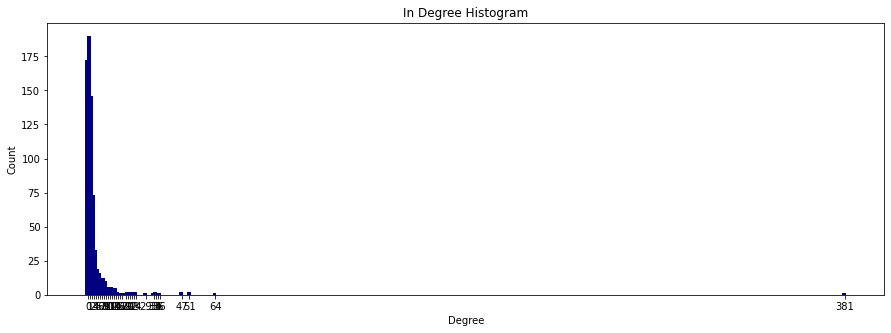

In [21]:
plot_deg_dist(G, True)

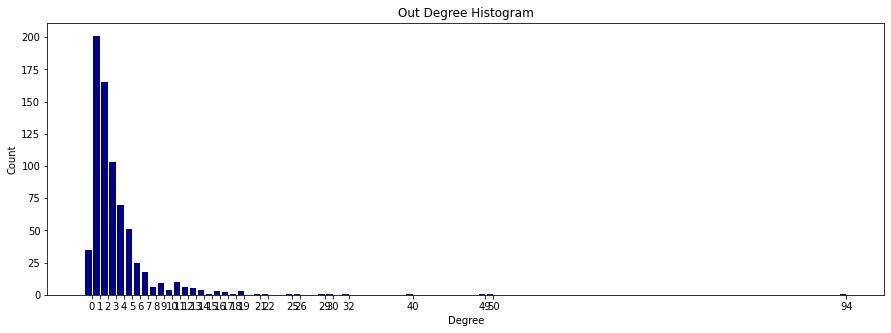

In [23]:
plot_deg_dist(G, False)

It can be seen that the shape of the plots are similar and they are both right skewed as expected of a network that can be assumed to have a degree of preferential attachment. Both plots support the conclusion that some characters are aboslutely central with regards to both in and out degree, whereas many characters are only mentioned in a few other character pages. 

In [27]:
# Plot log degree distribution
def plot_loglog_degree_histogram(G, b, normalized=True):
    if b:
        y = sorted([d for n, d in G.in_degree()], reverse=True)
    else:
        y = sorted([d for n, d in G.out_degree()], reverse=True)
    
    #y = nx.degree_histogram(G)
    
    x = np.arange(0,len(y)).tolist()
    
    n_nodes = G.number_of_nodes()
    
    if normalized:
        for i in range(len(y)):
            y[i] = y[i]/n_nodes
    plt.figure(figsize=(15,5))
    if b:
        plt.title('\nDistribution Of Node Linkages w.r.t. In-degree (log-log scale)')
    else:
        plt.title('\nDistribution Of Node Linkages w.r.t. Out-degree (log-log scale)')
    plt.xlabel('Degree\n(log scale)')
    plt.ylabel('Number of Nodes\n(log scale)')
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(x, y, 'o')
    plt.show()

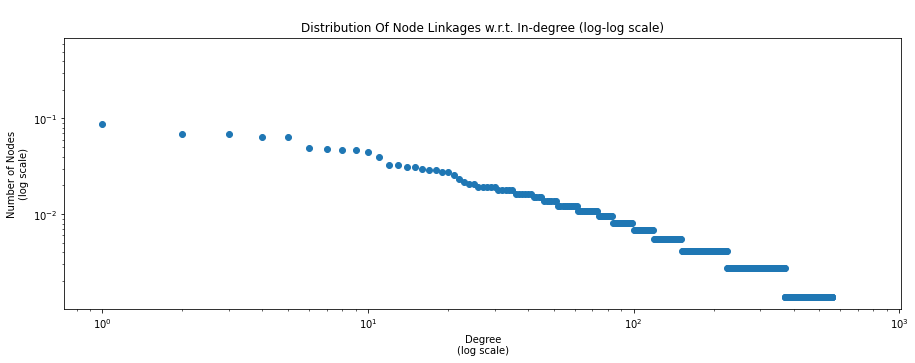

In [28]:
plot_loglog_degree_histogram(G,True)

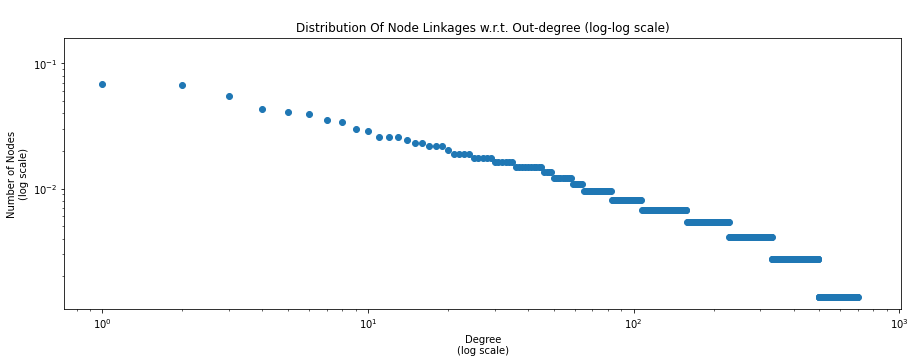

In [29]:
plot_loglog_degree_histogram(G,False)

When assessing the loglog degree distributions of in and out degree it can be seen that they look virtually identical on both shape and scale. Both can be said to follow a power law relationship indicating a scale-free network.

In [30]:
# Select max in-degree
deg = G.in_degree()
deg_vals = dict(deg).items()
max(deg_vals, key = lambda x: x[1])

('Geralt of Rivia', 381)

Just to see who is the most connected character based on in degree, the above code was executed. Unsurprisingly it is Geralt of Rivia, with 378(!) connections. 

In [31]:
# Select max out-degree
deg = G.out_degree()
deg_vals = dict(deg).items()
max(deg_vals, key = lambda x: x[1])

('Gwent players', 94)

With regards to out degree something a bit more interesting is revealed about the network. On the Witcher wiki, there are specific "character" pages listing all of a type of non playable character (NPC) in the games. In this case the card game Gwent which can be played in the Withcer III, the Wild Hunt, has many players one can challenge across the continent. Therefore this list which is registered as a character points to all of the possible Gwent opponent making it the character with the largest out degree. It could be argued that these should have been removed, but it was chosen to keep them as they act as a intermediary link to a lot of characters. 

In [32]:
def top_n_degree(G, n):
    degIn = G.in_degree()
    degIn_vals = dict(degIn)
    ins = str(sorted(degIn_vals, key=degIn_vals.get, reverse=True)[:n])

    degOut = G.out_degree()
    degOut_vals = dict(degOut)
    outs = str(sorted(degOut_vals, key=degOut_vals.get, reverse=True)[:n])
    
    print("Top " + str(n) + " characters based on In-degree: " + ins + "\n")
    print("Top " + str(n) + " characters based on Out-degree: " + outs)


In [33]:
top_n_degree(G, 5)

Top 5 characters based on In-degree: ['Geralt of Rivia', 'Ciri', 'Dandelion', 'Yennefer of Vengerberg', 'Foltest']

Top 5 characters based on Out-degree: ['Gwent players', 'Geralt of Rivia', 'The Witcher journal character entries', 'The Witcher 3 merchants', 'Ciri']


Again, unsurpringly to a fan of the Witcher universe, the main characters are the ones that have the largest in degree. The story bases around Geralt, Ciri, Dandelion, Triss and Yennefer and as they all travel the continent they will meet many characters leading to them having a large in degree. 

When looking at the out degree there are three character group pages present including the Gwent players. This makes sense. More interestingly Geralt and Ciri are present as well, so they are not only mentioned in many pages but also mention the characters they meet along the way. 

In [34]:
def powerlaw_values(G):
    in_deg = sorted([d for n, d in G.in_degree()], reverse=True)
    out_deg = sorted([d for n, d in G.out_degree()], reverse=True)
    in_fit = pw.Fit(in_deg, xmin=0)
    out_fit = pw.Fit(out_deg, xmin=0)
    print("Exponent for the in-degree distribution: " + str(in_fit.power_law.alpha) + "\n" + "Exponent for the out-degree distribution: " + str(out_fit.power_law.alpha))


In [37]:
powerlaw_values(G)

Exponent for the in-degree distribution: 2.613274371861541
Exponent for the out-degree distribution: 3.3877619711669564
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/root/venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Finally the powerlaw exponents are found using the powerlaw package. The exponents are large (above one) for both the in and out degrees. This means that the power law relation approximates the shape of a steep exponential function. This property is the same as a Barabasi Albert network, a network with preferential attachment. With this information along with the conclusions drawn above there can be said to be preferential attachment in the Witcher network. 

### Tools, theory and analysis
In the following section the employed tools, theory and analyses will be shown and discussed. The topics in question will be:

- Comparison to random networks
- Wordclouds with TF-IDF
- Communities and LDA
- Sentiment analysis

#### Comparison to random networks
In order to understand the structure of the Witcher network better, some visual comparisons were created to provide the user with an interactive way of understanding networks and their connections. This ties into the basic statistics section above and is a natural progression on the website, should the user choose to follow the structure and go through the topics in order.

In the following the Witcher graph is compared to a random graph, with the same size and connection probability of the Witcher graph. A comparrison is first made of the degreedistributions of both graphs.

In [38]:
uG = G.to_undirected()
uG.number_of_nodes()

733

In [39]:
def plot_degreedist_comparison(G): #G is a directed graph
    uG = G.to_undirected() #Get the undirected graph

    avg_deg = sum(dict(uG.degree()).values()) / uG.number_of_nodes() #Average degree of undir graph
    nGNodes = uG.number_of_nodes()
    p = avg_deg/(nGNodes - 1) # Connection prob
    erG = nx.generators.random_graphs.erdos_renyi_graph(nGNodes, p) #Erdos Reyni graph corresponding to the Witcher graph 

    # Degrees for Witcher
    degree_sequence = sorted([d for n, d in uG.degree()], reverse=True)  
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # Degrees for random
    rand_degree_sequence = sorted([d for n, d in erG.degree()], reverse=True)  
    rand_degree_count = collections.Counter(rand_degree_sequence)
    r_deg, r_cnt = zip(*rand_degree_count.items())

    #Plot object
    fig, axs = plt.subplots(2, figsize=(15,10))

    #Title and layout
    fig.suptitle("Degree histogram for Witcher (top) and Erdos-Reyni/random (bottom)")
    fig.tight_layout(pad=3.0)

    #Witcher degree dist
    axs[0].bar(deg, cnt, width=2.0, color='g')
    axs[0].set_xticks([d + 0.4 for d in deg])
    axs[0].set_xticklabels(deg)

    #Random degree dist
    axs[1].bar(r_deg, r_cnt, width=2.0, color='g')
    axs[1].set_xticks([d + 0.4 for d in r_deg])
    axs[1].set_xticklabels(r_deg)

    # Set common labels
    fig.text(0.5, 0.04, 'Degree', ha='center', va='center')
    fig.text(0.001, 0.5, 'Count', ha='center', va='center', rotation='vertical')

    plt.show()
    print("Witcher edges: " + str(uG.number_of_edges()) + "\n" + "Erdos-Réyni edges: " + str(erG.number_of_edges()))

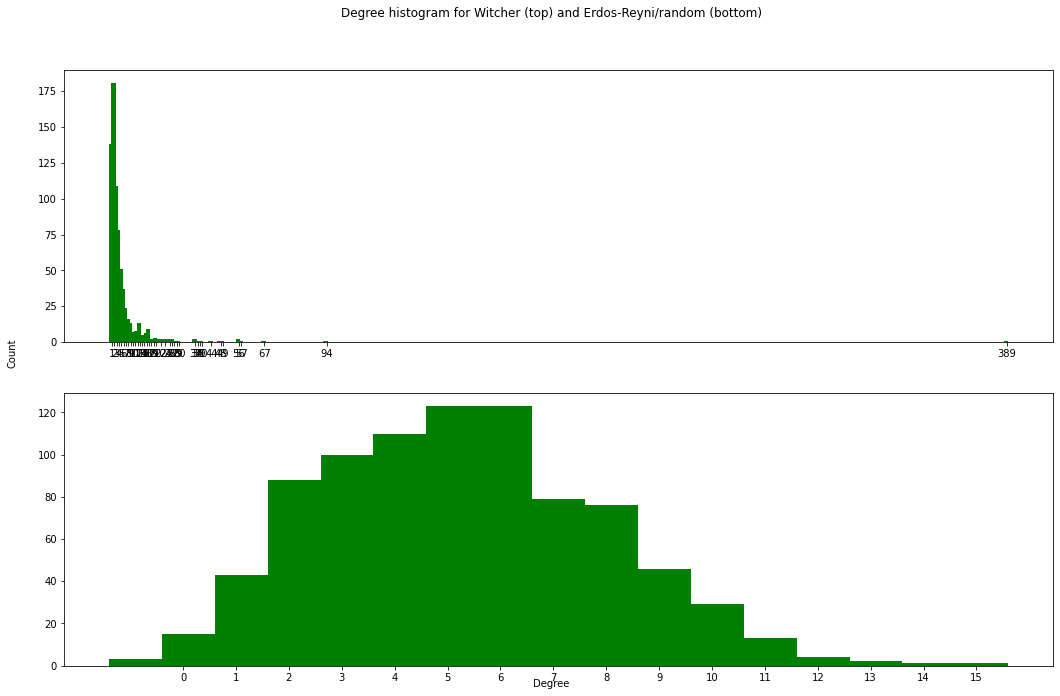

Witcher edges: 2110
Erdos-Réyni edges: 2082


In [40]:
plot_degreedist_comparison(G)

From the degree distribution plots it is clear that the Witcher network in no way resembles an Erdos Renyi graph in this aspect. The Erdos Renyi graph appears closer to a normal distribution of degrees, while the Witcher graph has a heavily right-skewed degree distribution, with many nodes having relatively few connections and a few nodes with many connections. 

For the second comparisson the loglog degree histograms of the two networks are compared.

In [41]:
def plot_loglog_degree_histogram_comparison(G, normalized=True):
    uG = G.to_undirected() #Get the undirected graph

    avg_deg = sum(dict(uG.degree()).values()) / uG.number_of_nodes() #Average degree of undir graph
    nGNodes = uG.number_of_nodes()
    p = avg_deg/(nGNodes - 1) # Connection prob
    erG = nx.generators.random_graphs.erdos_renyi_graph(nGNodes, p) #Erdos Reyni graph corresponding to the Witcher graph 
    
    yG = nx.degree_histogram(G)
    
    xG = np.arange(0,len(yG)).tolist()
    
    n_nodes = G.number_of_nodes()
    
    if normalized:
        for i in range(len(yG)):
            yG[i] = yG[i]/n_nodes
    plt.figure(figsize=(15,5))
    plt.title('\nDistribution Of Witcher Node Linkages (log-log scale) ')
    plt.xlabel('Degree\n(log scale)')
    plt.ylabel('Number of Nodes\n(log scale)')
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(xG, yG, 'o')

    yerG = nx.degree_histogram(erG)
    
    xerG = np.arange(0,len(yerG)).tolist()
    
    n_nodes = erG.number_of_nodes()
    
    if normalized:
        for i in range(len(yerG)):
            yerG[i] = yerG[i]/n_nodes
    plt.figure(figsize=(15,5))
    plt.title('\nDistribution Of Erdos-Reyni Node Linkages (log-log scale) ')
    plt.xlabel('Degree\n(log scale)')
    plt.ylabel('Number of Nodes\n(log scale)')
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(xerG, yerG, 'o')

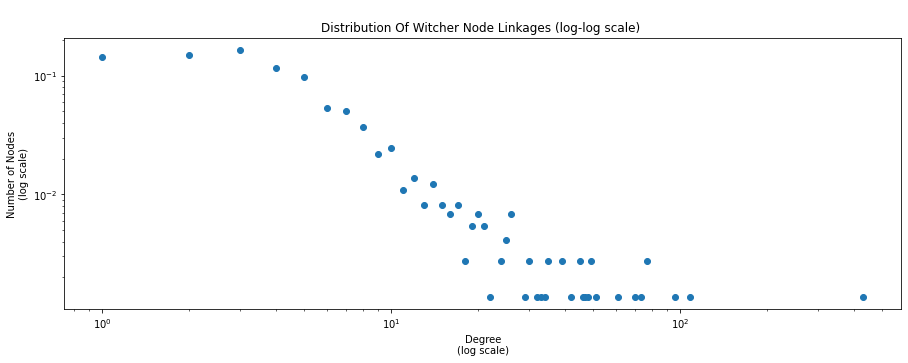

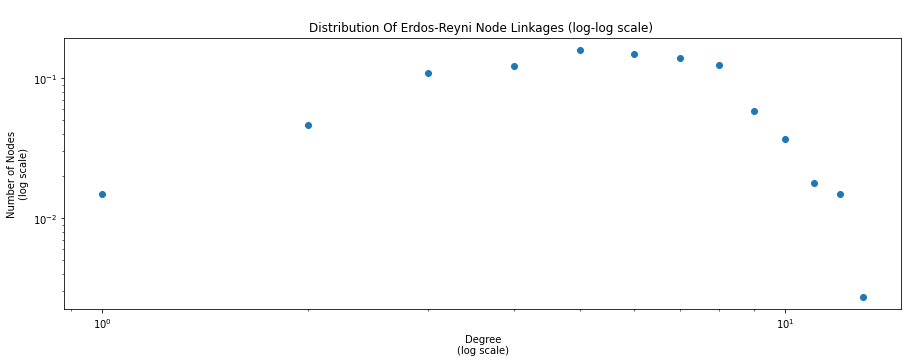

In [42]:
plot_loglog_degree_histogram_comparison(G)

From these plots it can be seen that they are again fairly different.

In conclusion the Witcher graph does not appear to resemble a random Erdos-Reyni graph in any shape.

#### Wordclouds
Wordsclouds were generated in order to provide the reader with an overview of what key words characterize the different groupings of characters. These key words are highlighted using term frequency and and inverse document frequency (TF-IDF). On the webpage one can filter on the atrributes associated with characters such that they get wordclouds for the races, nationalitites etc. Combined with Witcher-appropriate shape files, the user can dive deep into the groupings that their favorite hero belongs to. First the characters and their attributes are loaded.



In [43]:
df_characters = pd.read_csv("/work/socialgraph-witcher-analysis/data/cleaned_characters_attr.csv", index_col=0)

The function below creates a corpus of text from a chosen attribute such as Nationality. Then the attribute value could be Redanian such that one gets a corpus containing all characters, whose nationality is Redanian and their corresponding text.

In [44]:
def generate_text_corpus(df_characters, overall_attribute, attribute_value):
    #Generates the text corpuses for the chosen attribute
    data_root = r"data_all_clean"

    character_list = list(df_characters[df_characters[overall_attribute] == attribute_value]["title"].apply(lambda x: x + '.txt').values)
    wordlists = PlaintextCorpusReader(data_root, character_list)
    text = nltk.Text(wordlists.words())
    return text    

Then the function below uses the `generate_text_corpus` to create a dict containing several corpuses in order to show several wordclouds later. 

In [45]:
def generate_dict_corpuses(df_characters, overall_attribute, number_of_clouds, specific_choices = None):
    """
    Generates dictionary of text_corpuses from the overall attribute.
    """

    attribute_values = []
    
    #Add specific choices first
    if specific_choices is not None:
        attribute_values.extend(specific_choices)

    #Get top represented from the overall attribute and drop unwanted entries
    top_attributes = df_characters[overall_attribute].value_counts()
    top_attributes = top_attributes.drop(index = f"No {overall_attribute}")
    if specific_choices is not None:
        top_attributes = top_attributes.drop(index = specific_choices)   
    attribute_values.extend(list(top_attributes.index))
    attribute_values = attribute_values[:number_of_clouds]
    
    #Generate dictionary of corpuses
    texts_dict = {}
    for attribute in attribute_values:
        attribute_text = generate_text_corpus(df_characters, overall_attribute, attribute)
        texts_dict[attribute] = attribute_text
    
    return texts_dict 

The `make_cloud` function takes care of the visual aspects of the worldcloud. It needs the words that should be in the cloud as well as the attribute that defines the wordcloud. It defines a mask that the words should fit into, in this case a picture of a wolf, representing the School of the Wolf in which Geralt were trained to be a witcher. 

In [46]:
def make_cloud(wordcloud_string, attr):

    wolf_mask = np.array(Image.open("/work/socialgraph-witcher-analysis/images/wolf_icon.jpg"))

    wc = WordCloud(background_color="black", max_words=2000, mask=wolf_mask, collocations=False, colormap='RdBu')

    wc.generate(wordcloud_string)

    plt.figure(figsize=(10, 10))
    plt.title(f"{attr} Wordcloud")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Then to generate the actual text to be in the wordclouds. The function takes a dict containing text corpuses and prepares TF and IDF dictionaries using the text. The TF part contains the number of times each word appears in each text and the IDF is a calculation based on the number of documents each word appears in. Thus by multiplying these values, words which appear often and are exclusive to the text we want to look at, recieve a higher score. The TF-IDF scores are then saved and fed into the visualization function. 

In [47]:
def generate_word_clouds(texts_dict):
    #Make TC of TF dictionary
    attribute_dict = {}
    for attr in texts_dict.keys():
        term_dict = {}
        for key, value in FreqDist(texts_dict[attr]).items():
            term_dict[key] = value
        attribute_dict[attr] = term_dict
    #Make IDF dictionary

    gathered_texts = list(list(texts_dict.values())[0])
    for text in list(texts_dict.values())[1:]:
        gathered_texts.extend(list(text))

    idf_dict = {}
    for word in np.unique(gathered_texts):
        number_of_documents = 0
        for attr in texts_dict.keys():
            if word in attribute_dict[attr].keys():
                number_of_documents += 1
        idf_dict[word] = math.log10(len(texts_dict.keys())/number_of_documents)

    #Generate Wordclouds
    for attr in attribute_dict.keys():
        wordcloud_string = ''
        for word in attribute_dict[attr].keys():
            word_mod = word + ' ' 
            tf_idf_score = round(attribute_dict[attr][word] * idf_dict[word])
            wordcloud_string += word_mod * tf_idf_score
        make_cloud(wordcloud_string, attr)    


Then the functions are used to generate some nice wordclouds, based on the TF-IDF scores of each word:

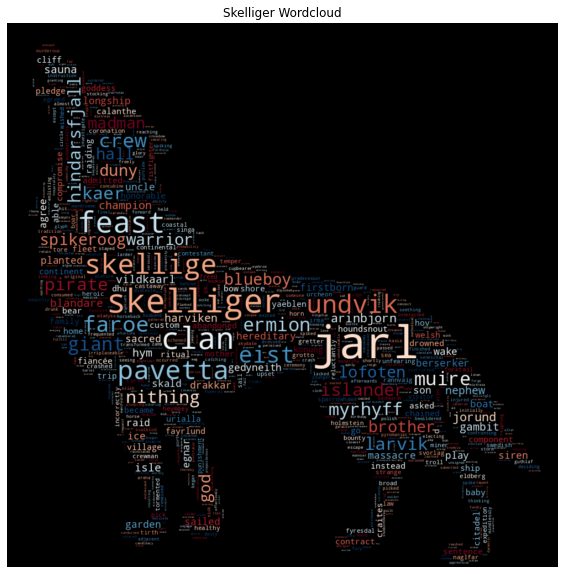

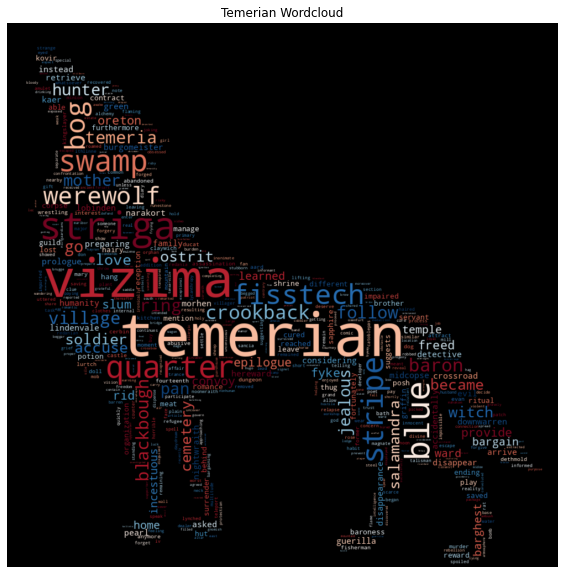

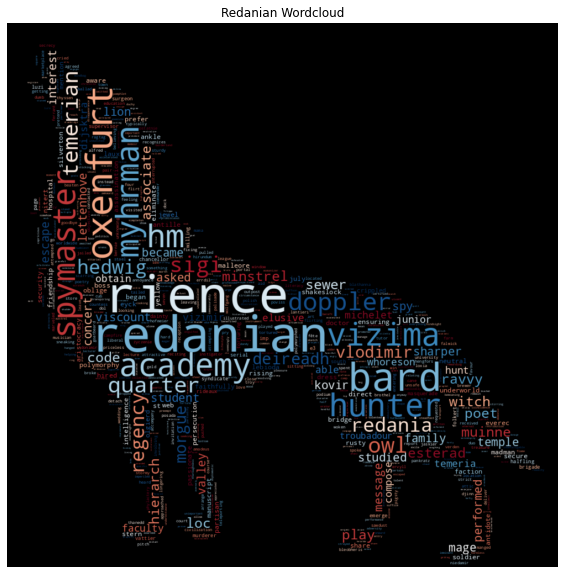

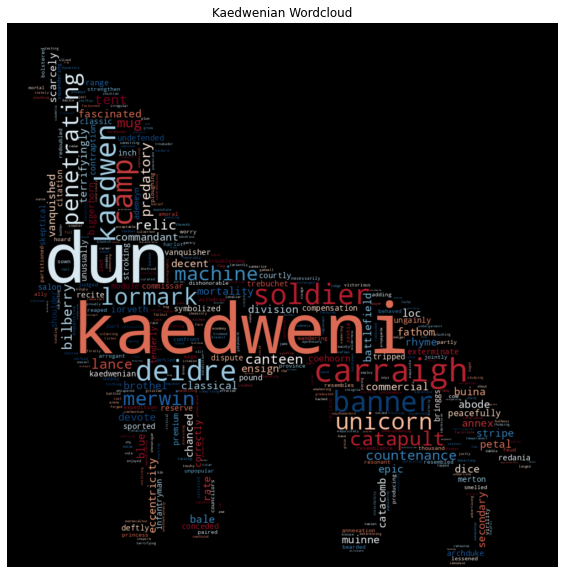

In [48]:
texts_dict = generate_dict_corpuses(df_characters, 'Nationality', 4, ['Skelliger', 'Temerian'])
generate_word_clouds(texts_dict)

The wordsclouds show several interesting points here. The function specifies that we want four clouds that are based on Nationality. These would normally be the four largest groups, but in this case it was specified that the nationalities Skelliger and Temerian should be present. Then Skellige and Temeria will be represented as well as the two largest groups apart from these. On the website, wordclouds are only generated and shown according to the users choice of overall attribute and the specific group of characters. 

### Communities
In working with large groups of characters it might be beneficial to look at them as groups, but that raises the question - How should they be grouped? This is answered by doing community detection on the graph, visualizing it and examining the communities to better understand what brings them together.

First, the graph is loaded and the best partition of communities is computed using the Louvain algorithm, which works to maximize the modularity score of the partitions. This means that the algorithm attempt to maximize the number of connections within a community, while minimixing the number of connections between communities.

In [49]:
#Read the GCC
G = nx.read_gpickle("WG.gpickle")

G = G.to_undirected()

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

# compute the best partition
partition = community_louvain.best_partition(G0, random_state=1)

Force Atlas object is set up to represent the graph more nicely later.

In [51]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G0, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:15<00:00, 132.22it/s]BarnesHut Approximation  took  3.84  seconds
Repulsion forces  took  9.80  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.44  seconds



Then one can draw the graph. Here, each node is colored according to the partition found above.

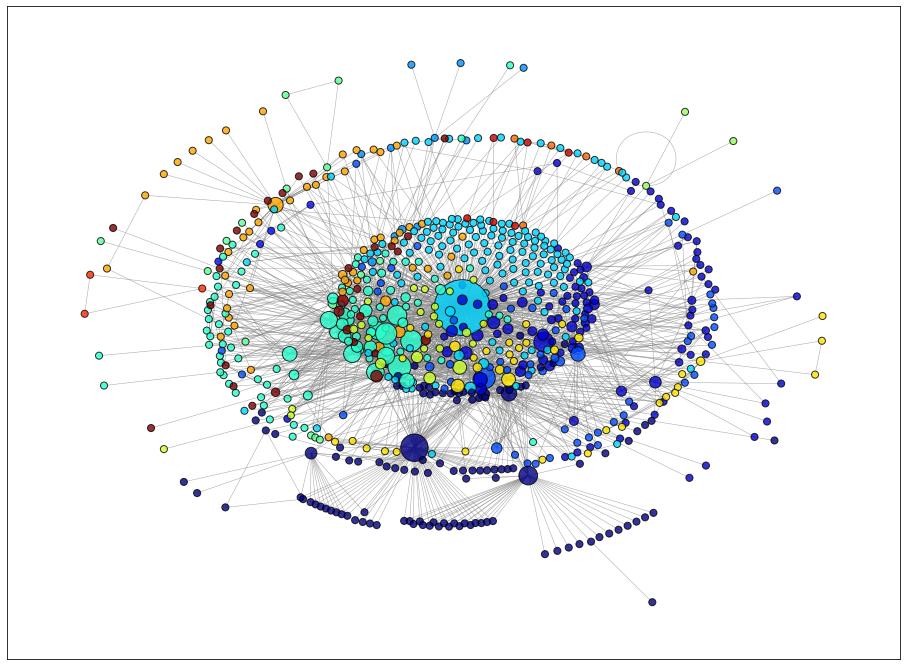

In [55]:
d = dict(G0.degree())
# draw the graph
plt.figure(figsize=(16, 12))
pos = nx.kamada_kawai_layout(G0)
# color the nodes according to their partition
cmap = cm.get_cmap('jet', max(partition.values()) + 1)
nx.draw_networkx_nodes(G0, pos, partition.keys(), node_size=[max(v * 8, 50) for v in d.values()],
                       cmap=cmap, node_color=list(partition.values()), alpha=0.8)
nx.draw_networkx_edges(G0, pos, alpha=0.7, width=0.5, edge_color = 'grey')
ax = plt.gca() # to get the current axis
#ax.set_facecolor("#000000")
ax.collections[0].set_edgecolor("#000000")

plt.show()

The graph clearly shows that the closely linked characters belong in communities together. There seem to be 5-6 central ones in the core of the graph and several more around the central mass of nodes. More can be said about them later. Below, its shown that a total of 16 communities are found.

In [56]:
print(f"Number of communities found: {max(partition.values())+1}")

Number of communities found: 16


Below, the degree of modularity is shown. A value of 0.55 can be said to be a fairly high degree as 1 is the max and 0 is as good as a completely random partition. This indicates that the connections between the character nodes in the groups are fairly dense, i.e. there are many connections between them. Also, the connections to other groups in the partition are likely sparse, i.e. few connections leaving the cluster. This makes sense when looking at a setting like the Witcher. It is a medieval world where normal people do not travel long distances and are born and die in the same village. Also the sense of nationality is a theme within the Witcher universe and with different warring factions all across the continent, people are likely in tightly knit communities unwilling to fraternize with the enemy.  

In [57]:
print(f'The value of modularity is: {community_louvain.modularity(partition, G0)}')

The value of modularity is: 0.5508758787987692


In [58]:
community = list()
community_size = list()
for i in range(max(partition.values())+1):
    community.append(i)
    community_size.append(Counter(partition.values())[i])
print(community_size)

[117, 108, 4, 58, 11, 152, 103, 15, 3, 23, 40, 55, 5, 3, 6, 30]


Above, the size of the communities can be seen. It is clear that there are four large communities and 12 of varying size, some very small. This again makes sense, as the small communities might be villages or a guild of specific characters such as druids or even small families situated in remote locations. The larger communities likely live in the large cities and thus interact with many different people. The sizes of the communities are also visualized in a bar chart below.

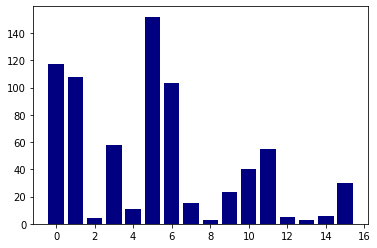

In [60]:
plt.bar(range(max(partition.values())+1), community_size, color='navy')
plt.show()

In the following function, the communities are named after the top three most connected characters. This should give an indication of which characters belong to it and who defines the groups. 

In [61]:
def name_communities(G0, partition, community_size):
    # Find all node degress
    degrees = [val for (node, val) in G0.degree()]

    # Create node degree dataframe
    df_community = pd.DataFrame()
    df_community["Name"] = list(partition.keys())
    df_community["Community"] = list(partition.values())
    df_community["Degree"] = degrees

    df_community_group = df_community.groupby(['Community', 'Name', 'Degree']).count().reset_index()
    df = df_community_group.copy()

    df_community_group = df_community_group.sort_values('Degree', ascending = False).groupby('Community').head(3)

    df_community_group = df_community_group.groupby('Community')['Name'].agg(lambda col: '-'.join(col)).reset_index()
    df_community_group.columns = ['CommunityID', 'CommunityName']
    df_community_group["CommunitySize"] = community_size
    return df_community_group, df

The names are saved and added to the dataframe such that it becomes clear which characters belong where. 

In [67]:
df_com_names, df = name_communities(G0, partition, community_size)
pd.merge(df, df_com_names, left_on="Community", right_on="CommunityID")

,Community,Name,Degree,CommunityID,CommunityName,CommunitySize
0,0,Aldert Geert,6,0,Gwent players-The Witcher 3 merchants-Blacksmith,117
1,0,Anisse,4,0,Gwent players-The Witcher 3 merchants-Blacksmith,117
2,0,Anselm (merchant),5,0,Gwent players-The Witcher 3 merchants-Blacksmith,117
3,0,Armorer,17,0,Gwent players-The Witcher 3 merchants-Blacksmith,117
4,0,Armorer (Hierarch Square),1,0,Gwent players-The Witcher 3 merchants-Blacksmith,117
...,...,...,...,...,...,...
728,15,Otrygg an Hindar,2,15,Crach an Craite-Bran Tuirseach-Cerys an Craite,30
729,15,Svanrige Tuirseach,7,15,Crach an Craite-Bran Tuirseach-Cerys an Craite,30
730,15,Udalryk an Brokvar,5,15,Crach an Craite-Bran Tuirseach-Cerys an Craite,30
731,15,Uve Jabberjaw,2,15,Crach an Craite-Bran Tuirseach-Cerys an Craite,30


Then, on to what defines the communities. The following function finds the top n words in a community, further elaborating on what defines the created communities. This is done using TF-IDF again and applying it on the grouped texts of the communities that were just defined. Thus the most exclusive words for each community is found, which should be very characteristic of the community as a whole.  

In [70]:
def community_top_words(chosen_comms, df_com_names, partition, number_of_words):
    chosen_comms_idx = []
    for i in chosen_comms:
        chosen_comms_idx.append(df_com_names.index[df_com_names['CommunityName'] == i].tolist()[0])

    
    #Generate dictionary of community texts
    texts_dict = {}
    data_root = "/work/socialgraph-witcher-analysis/notebooks/data_all_clean"

    for idx in chosen_comms_idx:
        char_list = []
        for char in partition.keys():
            if partition[char] == idx:
                char_list.append(f"{char}.txt")
        
        wordlists_community = PlaintextCorpusReader(data_root, char_list)
        community_texts = nltk.Text(wordlists_community.words())
        texts_dict[idx] = community_texts


    #Make TF dictionary
    TF_dict = {}
    for comm in texts_dict.keys():
        term_dict = {}
        for key, value in FreqDist(texts_dict[comm]).items():
            term_dict[key] = value/len(texts_dict[comm])
        TF_dict[comm] = term_dict


    #Get list of all words from all communities
    gathered_texts = list(list(texts_dict.values())[0])
    for text in list(texts_dict.values())[1:]:
        gathered_texts.extend(list(text))

    #Make IDF dictionary
    idf_dict = {}
    for word in np.unique(gathered_texts):
        number_of_documents = 0
        for comm in texts_dict.keys():
            if word in TF_dict[comm].keys():
                number_of_documents += 1
        idf_dict[word] = math.log10(len(texts_dict.keys())/number_of_documents)

    #Make tf_idf_dict
    tf_idf_dict = copy.deepcopy(TF_dict)
    for comm in tf_idf_dict.keys():
        for word in tf_idf_dict[comm].keys():
            tf_idf_dict[comm][word] = tf_idf_dict[comm][word] * idf_dict[word]

    #Make prints of top n words for each chosen community
    for key in tf_idf_dict.keys():
        print(f"Top "+ str(number_of_words) + " words from the " + str(chosen_comms[chosen_comms_idx.index(key)]) + " community, based on TF-IDF is:")
        print(sorted(tf_idf_dict[key], key=tf_idf_dict[key].get, reverse=True)[:number_of_words])
        print("")    

Finally three of the top communities were shown along with their top 5 words. The first, consisting of Geralt, his friend the dwarf Zoltan Chivay and the King of Beggars, Francis Bedlam, has the top words *torque*, *whoreson*, *started*, *revealed*, *brother*. First, *whoreson* is the nickname of Francis Bedlam and if he defines the community there are likely a ton of references to him as he is one of the four crime lords of Novigrad. This also ties into *started* and *revealed* as he sets plans and executes on them. This can be said for Geralt too, as he often starts quests and reveals secrets. *Brother* could allude to the relationship between Zoltan and Geralt, but also the Novigrad criminal gang that follows Francis. Finally *Torque* is the name of a Sylvan, which in roman mythology would be called a faun, a half goat-half man. He and Geralt are close. 

In the Gwent, Merchants and Blacksmiths community, the words that define them are *journeyman*, *armorer*, *blacksmith*, *amateur* and *meteorite*. The first four words speak of either a profession or a quality of goods, something that ties in perfectly with this community that sounds to be made of card players and merchants. Finally *meteorite* is a material that can be used to strengthen swords, something that both soldiers and witchers alike could use. 

For the Ciri, Triss and Yennefer community, the top words refer to the witches and mages of the universe. Yennefer and Triss are witches and are some of the key figures in the story, along with Ciri, who also posseses magical powers and abilities. The witches are *advisors* to the kings and have a *lodge* of sorceresses. *Saskia* is a dragon, which has a human form and has many encounters with the witches and *Dethmold* is a mage from the Witcher 2 game.



In [75]:
chosen_comms = ['Geralt of Rivia-Zoltan Chivay-Francis Bedlam', 'Gwent players-The Witcher 3 merchants-Blacksmith', 'Ciri-Triss Merigold-Yennefer of Vengerberg']
community_top_words(chosen_comms, df_com_names, partition, 5)

Top 5 words from the Geralt of Rivia-Zoltan Chivay-Francis Bedlam community, based on TF-IDF is:
['torque', 'whoreson', 'started', 'revealed', 'brother']

Top 5 words from the Gwent players-The Witcher 3 merchants-Blacksmith community, based on TF-IDF is:
['journeyman', 'armorer', 'blacksmith', 'amateur', 'meteorite']

Top 5 words from the Ciri-Triss Merigold-Yennefer of Vengerberg community, based on TF-IDF is:
['saskia', 'síle', 'dethmold', 'lodge', 'advisor']



### LDA
To analyze further on the text data scraped from the wiki, topic modelling was applied using the Latent Dirichlet Allocation (LDA) topic model. LDA topic modelling was applied, because it would be interesting to see if the collected information about the characters, could be classified and described by a few overall topics. And to see what topics could describe the vast universe of The Witcher.  

In [76]:
def remove_stopwords(texts, stop_words):
    return [[word for word in doc 
             if word not in stop_words] for doc in texts]

In [77]:
#LDA Communities

chosen_comms_idx = []
for i in chosen_comms:
    chosen_comms_idx.append(df_com_names.index[df_com_names['CommunityName'] == i].tolist()[0])

stop_words = stopwords.words('english')
stop_words.extend(['however', 'though', 'would', 'later', 'could'])

#Generate dictionary of community texts
comm_data = []
data_root = "/work/socialgraph-witcher-analysis/notebooks/data_all_clean"

for idx in chosen_comms_idx:
    char_list = []
    for char in partition.keys():
        if partition[char] == idx:
            char_list.append(f"{char}.txt")
    
    wordlists_community = PlaintextCorpusReader(data_root, char_list)
    words = wordlists_community.words()
    comm_data.append(words)

comm_data = remove_stopwords(comm_data, stop_words)

In [78]:
#LDA all characters
stop_words = stopwords.words('english')
stop_words.extend(['however', 'though', 'would', 'later', 'could'])

#Generate dictionary of community texts
comm_data = []
data_root = "/work/socialgraph-witcher-analysis/notebooks/data_all_clean"

filelists = PlaintextCorpusReader(data_root, '.*')
the_files = [f for f in listdir(data_root) if isfile(join(data_root, f))]

for char in the_files:
    words = filelists.words(char)
    comm_data.append(words)

comm_data = remove_stopwords(comm_data, stop_words)

The model takes in a bag of words for each documents in the corpus. A TF-IDF model is then applied in similar fashion as earlier, such that only frequent and exclusive words are used for the topic modelling. Running the LDA model on this data creates a number of topics, which in theory should describe the overall themes or *topics* present in the data. 

The LDA analysis was applied using both the grouped text of the detected communities and using the text from each character seperately. Ultimately, the LDA-model which uses every character text seperately creates more interesting topics, which is also the one used on the website.

In [79]:
# Create Dictionary
id2word = corpora.Dictionary(comm_data)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in comm_data]

model = TfidfModel(corpus=corpus, normalize=True) #fit model


vector = [model[corpus[i]] for i in range(len(comm_data))] #apply tf_idf

In [80]:
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=vector,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"crafting" + 0.001*"sell" + 0.001*"deck" + 0.001*"component" + '
  '0.001*"novigrad" + 0.001*"kaer" + 0.001*"play" + 0.001*"1272" + '
  '0.001*"time" + 0.001*"help"'),
 (1,
  '0.001*"novigrad" + 0.001*"1272" + 0.001*"perch" + 0.001*"crow" + '
  '0.001*"card" + 0.001*"baron" + 0.001*"play" + 0.001*"velen" + 0.001*"help" '
  '+ 0.001*"game"'),
 (2,
  '0.001*"blue" + 0.001*"stripe" + 0.001*"sell" + 0.001*"arena" + '
  '0.001*"crafting" + 0.001*"house" + 0.001*"novigrad" + 0.001*"found" + '
  '0.001*"player" + 0.001*"vizima"'),
 (3,
  '0.001*"village" + 0.001*"chapter" + 0.001*"sell" + 0.001*"killed" + '
  '0.001*"player" + 0.001*"found" + 0.001*"game" + 0.001*"bog" + 0.001*"deck" '
  '+ 0.001*"crafting"'),
 (4,
  '0.001*"deck" + 0.001*"play" + 0.001*"brother" + 0.001*"skellige" + '
  '0.001*"help" + 0.001*"novigrad" + 0.001*"house" + 0.001*"village" + '
  '0.001*"sell" + 0.001*"brothel"')]


Finally a tool called *pyLDAvis* was used to display and interpret the topics generated by the LDA topic modelling. It generates and interactive visualization of the topics, which provides more information and interpretability about the generated topics. From some of the key words defining the generated topics it is clear that the different merchants of the games heavily influence the overall topics generated with words like *crafting, sell and component*, along with the Gwent playing characters (a card based minigame in the series) with words like *deck, game and play*. Many of the words are also reoccuring in the different topics. It therefore appear that the model is having a hard time determining the different topics covering the characters.   

In [81]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim
import pickle 
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/work/socialgraph-witcher-analysis/notebooks/ldavis_prepared/lda'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/work/socialgraph-witcher-analysis/notebooks/ldavis_prepared/lda'+str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.001807 -0.013686       1        1  48.139233
1      0.015440  0.002574       2        1  23.518791
3     -0.003026  0.000182       3        1  12.447839
4     -0.006181  0.008859       4        1  10.359604
2     -0.004426  0.002071       5        1   5.534533, topic_info=         Term       Freq      Total Category  logprob  loglift
1802     blue  34.000000  34.000000  Default  30.0000  30.0000
3059   stripe  30.000000  30.000000  Default  29.0000  29.0000
513   brothel  27.000000  27.000000  Default  28.0000  28.0000
613     arena  34.000000  34.000000  Default  27.0000  27.0000
593   village  56.000000  56.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
424    friend   2.620105  45.022447   Topic5  -7.7611   0.0502
324      time   2.784954  72.357588   Topic5  -7.7000  -0.3632
226      near   2.701043  58.165024   Topic5  -7.7306  -0.1755
419     fight   2.644783  49.104911   Topic5  -7.7517  -0.0272
186      life   2.628790  47.556524   Topic5  -7.7578  -0.0012

[376 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
512       1  0.482409   1271
512       2  0.141885   1271
512       3  0.170262   1271
512       4  0.113508   1271
512       5  0.056754   1271
...     ...       ...    ...
2526      1  0.241440  youth
2526      2  0.563361  youth
2526      3  0.080480  youth
2526      4  0.080480  youth
2526      5  0.080480  youth

[1314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 5, 3])

In general it seems that the LDA-model has a tough time generating overall topics to the text data presented to it. Many of the topics overlap quite a lot and a lot of focus of the topics are on the merchants and Gwent players met throughout the Witcher universe. These are of course a key part of the universe of the games, but other than this, the model seems to have difficulties distinguishing other specific topics, which would describe the universe.

### Sentiment Analysis
In the following section the sentiment analysis of the characters will be detailed. This section will employ the VADER lexicon in order to determine the general state-of-mind of the characters in the series. While the data is scraped from the games' wiki, all the character pages contain information and lore from all types of media in which the characters are presented, thus quotes and sections of the books are a part of the collected files as well as simple descriptions. Therefore it was decided that it was sufficient to do sentiment analysis on that data only, instead of collecting new data. With more time one could extend the analysis to e.g. the scripts of the Netflix series episodes. These contain only first names denoting whom speaks, and also has camera angle descriptions so the cleaning of that text and subsequent mapping to fit the characters would be a huge task in itself, albeit interesting. Also, not all scripts are accessible to the public. Another approach could have been subtitles, but in these, the character speaking is not specified, again creating problems. 

First, to ensure that the data is clean the graph is imported. 

In [82]:
#Read the GCC
G = nx.read_gpickle("WG.gpickle")

G = G.to_undirected()

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

# compute the best partition
partition = community_louvain.best_partition(G0, random_state=1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/root/venv/lib/python3.7/site-packages/networkx/utils/decorators.py:5: DeprecationWarning: read_gpickle is deprecated and will be removed in 3.0.Use ``pickle.load(path)``
  import warnings


Then the degrees of the nodes are added to a dataframe along with the character name and the community they belong to.

In [83]:
# Find all node degress
degrees = [val for (node, val) in G0.degree()]

# Create node degree dataframe
df_community = pd.DataFrame()
df_community["Name"] = list(partition.keys())
df_community["Community"] = list(partition.values())
df_community["Degree"] = degrees

df_community_group = df_community.groupby(['Community', 'Name', 'Degree']).count().reset_index()

df_community_group = df_community_group.sort_values('Degree', ascending = False).groupby('Community').head(3)

df_community_group = df_community_group.groupby('Community')['Name'].agg(lambda col: '-'.join(col)).reset_index()
df_community_group.columns = ['CommunityID', 'CommunityName']

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The respective communities are added to the nodes in the graph as well.

In [84]:
# Add communities to each node 
df_community = pd.merge(df_community, df_community_group, left_on="Community", right_on="CommunityID")
community_names = df_community[["Name", "CommunityName"]].set_index('Name').T.to_dict('records')[0]
nx.set_node_attributes(G, community_names, name="community")

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Then, a function to calculate the Vader sentiment is created. It reads all the text associated with a nodes character and returns the Vader compound score between -1 and 1 where -1 is the most negative score and 1 the most positive in terms of sentiment. Above 0.05, the compound score is considered overall positive and inversely, below -0.05 it is considered overall negative.

In [85]:
def calculate_Vader_sentiment(node):
    try: 

        # The dialog for the character 
        with open(f"/work/socialgraph-witcher-analysis/notebooks/data_clean_texts/{node.replace(' ', '_')}.txt") as f:
            character_text = f.read()

        analyzer = SentimentIntensityAnalyzer()

        sentiment = analyzer.polarity_scores(character_text)["compound"]

        # Return average sentiment
        return sentiment

    except:
        return -99

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Then for each node the Vader compound score is added as an attribute.

In [86]:
for node in G0.nodes():
    G0.nodes()[node]["Vader_Sentiment"] = calculate_Vader_sentiment(node)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And converted into a dataframe.

In [87]:
df_sentiment = pd.DataFrame.from_dict(dict(G0.nodes(data=True)), orient='index').reset_index().rename(columns = {'index':'Name'})
df_sentiment.head()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Race,Gender,Nationality,Family,Profession,community,Vader_Sentiment
0,Innkeeper,No Race,No Gender,No Nationality,No Family,No Profession,Gwent players-The Witcher 3 merchants-Blacksmith,0.4404
1,The Witcher journal character entries,No Race,No Gender,No Nationality,No Family,No Profession,The Witcher journal character entries-Thaler (...,-0.2960
2,Abigail,Human,Female,Temerian,No Family,Witch,The Witcher journal character entries-Thaler (...,-0.9913
3,Adalbert (soldier),Human,Male,Temerian,No Family,Soldier,The Witcher journal character entries-Thaler (...,-0.1280
4,Adam (Murky Waters),Human,Male,Temerian,No Family,Poet,The Witcher journal character entries-Thaler (...,-0.9892


Then a function is created that partitions the dataframe with the sentiment scores, into a happy, an unhappy and a grouped dataframe from which the first two are made. These will make the moods of the characters clear. The happy and unhappy dataframes only consists of the five top characters within each group.

In [88]:
def create_sentiment_analysis(df_sentiment, attribute):
    df_grouped = df_sentiment[[attribute, "Vader_Sentiment"]].groupby(attribute).mean().reset_index()
    df_grouped['Vader_std'] = df_sentiment[[attribute, "Vader_Sentiment"]].groupby(attribute).std().reset_index()['Vader_Sentiment']

    df_happy = df_grouped.sort_values("Vader_Sentiment", ascending=False).head(5)
    df_unhappy = df_grouped.sort_values("Vader_Sentiment").head(5)
    return df_happy, df_unhappy, df_grouped

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Finally a function that can plot the sentiment of either all characters or a grouped collection of characters based on a selected attribute is created below. On the webpage the different attributes can be chosen in order to gain further insight into the sentiment of the different groups. Also, some general stats are made to show the overall sentiment of the Witcher universe.  

In [90]:
def make_plot(df_grouped, attribute):
    if attribute == 'Name':
        x = [i for i in df_grouped["Name"]]
        y = [i for i in df_grouped["Vader_Sentiment"]]
        cmap = plt.cm.get_cmap('viridis')
        color = cmap(y)

        for i in range(7):
            plt.figure(figsize=(24,3))
            plt.bar(x[(i*105):((i+1)*105)], y[(i*105):((i+1)*105)],color=color[(i*105):((i+1)*105),:], capsize=3)
            plt.xticks(rotation=45, horizontalalignment="right")
            plt.ylabel(f"Sentiment Score")
            plt.show()

    elif attribute == 'Profession':
        x = [i for i in df_grouped["Profession"]]
        y = [i for i in df_grouped["Vader_Sentiment"]]
        cmap = plt.cm.get_cmap('viridis')
        color = cmap(y)

        for i in range(2):
            plt.figure(figsize=(24,3))
            plt.bar(x[(i*80):((i+1)*80)], y[(i*80):((i+1)*80)],color=color[(i*80):((i+1)*80),:], capsize=3)
            plt.xticks(rotation=45, horizontalalignment="right")
            plt.ylabel(f"Sentiment Score")
            plt.show()


    else:
        cmap = plt.cm.get_cmap('RdYlGn')
        color = cmap(df_grouped['Vader_Sentiment'])

        plt.figure(figsize=(12,8))
        plt.bar(df_grouped[attribute], df_grouped['Vader_Sentiment'],  yerr=df_grouped['Vader_std'], color=color, capsize=3)
        plt.xticks(rotation=45, horizontalalignment="right")
        plt.ylabel(f"Sentiment Score")
        plt.show()


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


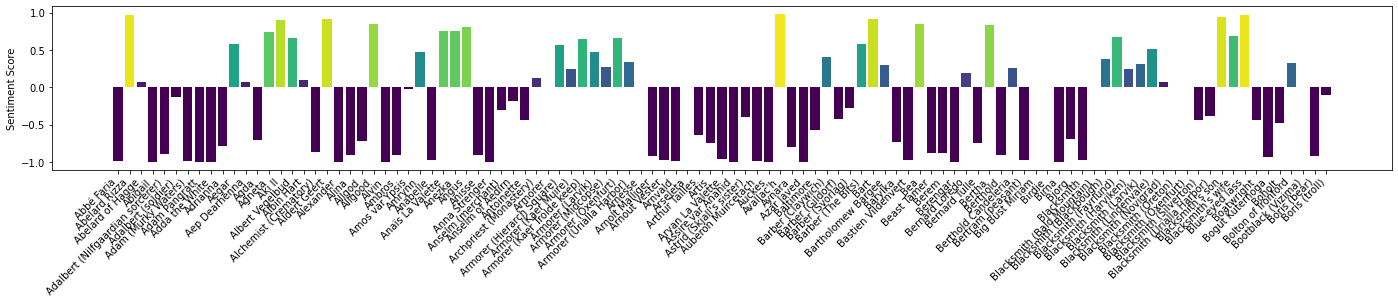

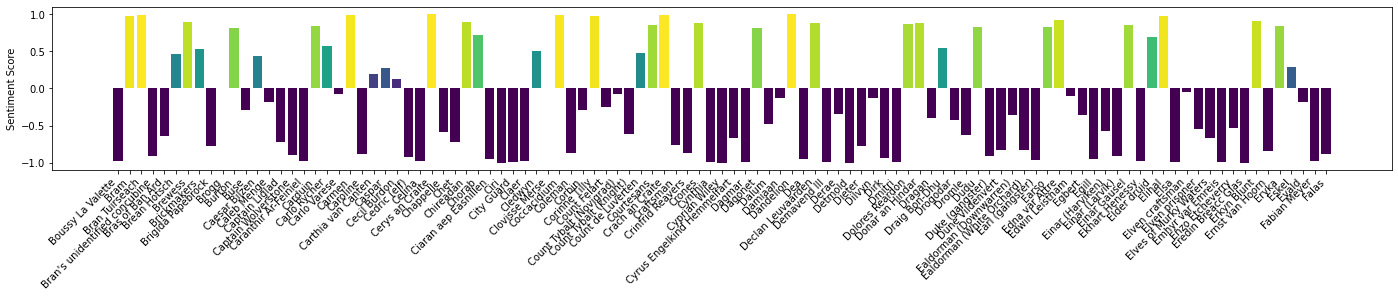

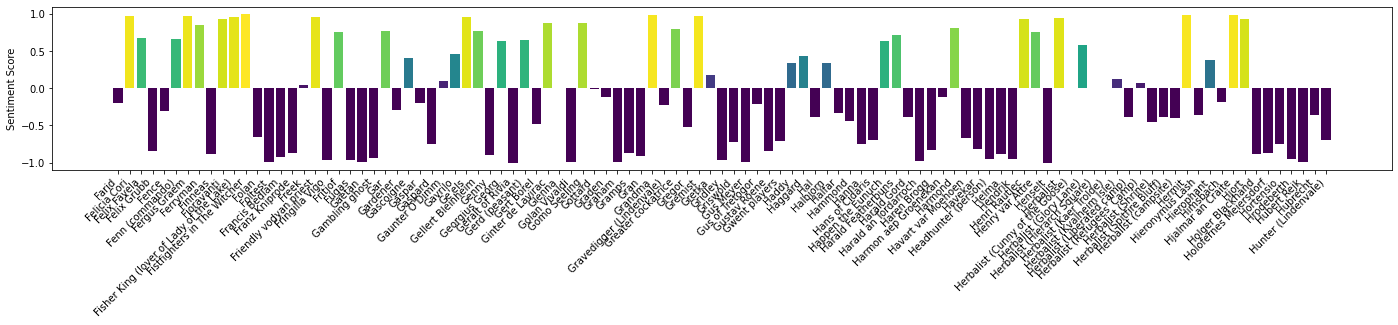

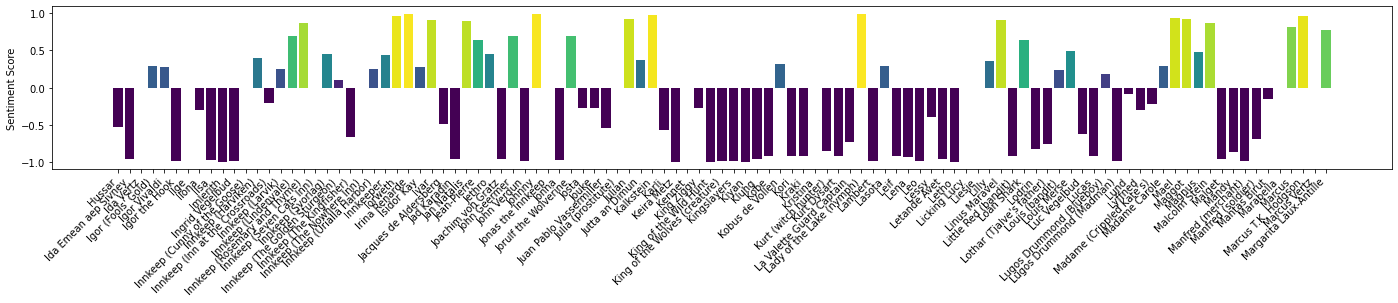

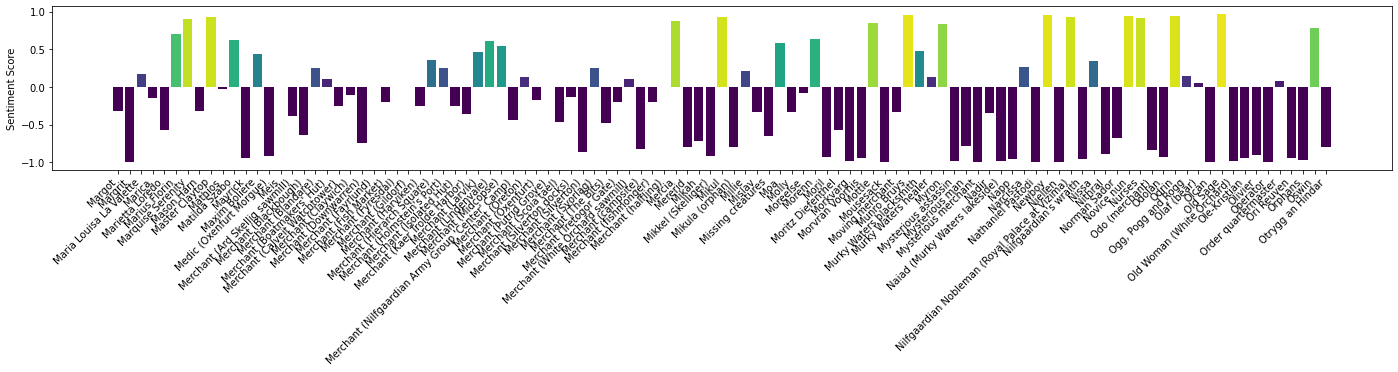

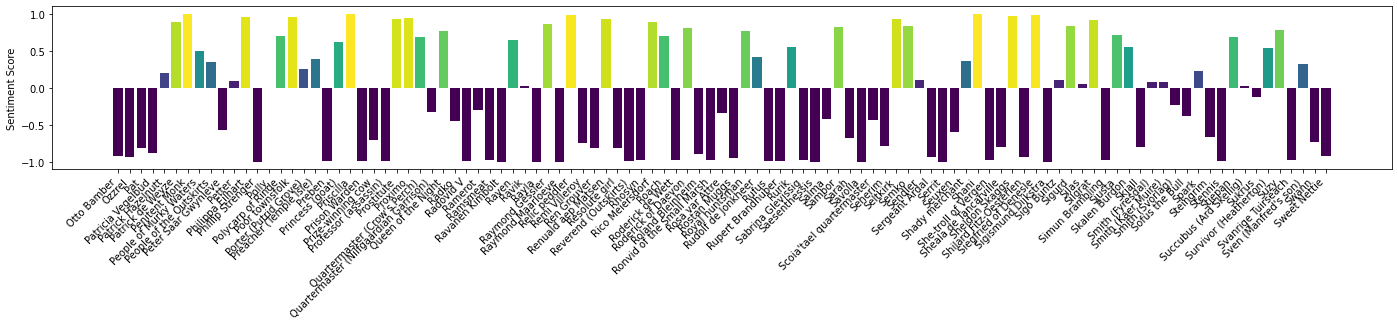

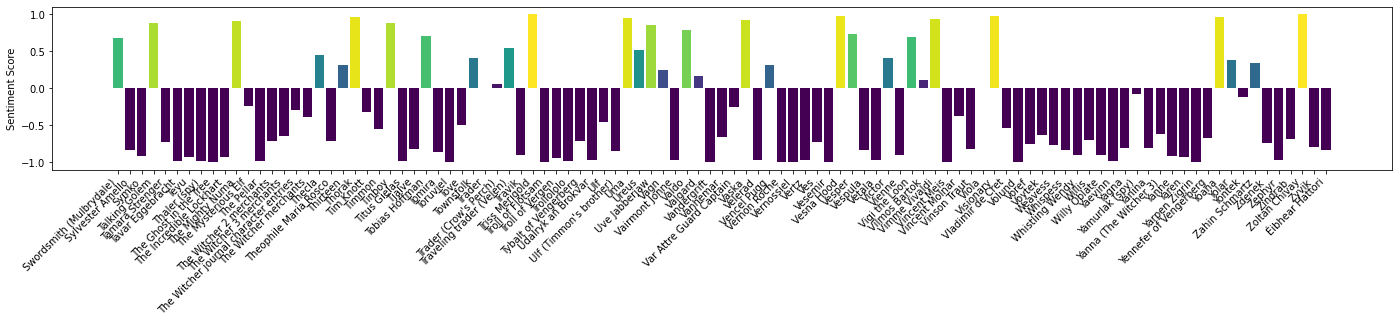

In [91]:
attribute = 'Name'
df_happy, df_unhappy, df_grouped = create_sentiment_analysis(df_sentiment, attribute=attribute)
make_plot(df_grouped, attribute=attribute)

The plot above shows the sentiment of all characters. From observation alone it can be seen that the general sentiment leans toward the negative side, with exceptions. The groupings created through attributes on the webpage show that if one chooses Race, the positive races only have a single character in them, again adding to the idea that most characters are negative. 

In [92]:
df_happy

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Vader_Sentiment,Vader_std
665,Triss Merigold,0.9997,NaN
599,Shani,0.9997,NaN
163,Dandelion,0.9997,NaN
221,Fistfighters in The Witcher,0.9984,NaN
132,Cerys an Craite,0.9978,NaN


The five happiest characters can be seen above. While there are tragic moments in Triss' life she generally is cheery and keeps a positive outlook, placing her as the happiest character in the universe. Shani was a medic and lived a long and fulfilling life. She is a good friend of Dandelion, another happy character. He is a bard and his life revolves around wine and adventure. Cerys an Craite is the daughter of the Skelligan ruler, Crach an Craite. She is stubborn and competetive but happy througout. She seeks to be the next ruler of Skellige even though she is not next in line, but as the Skellige Islands are democratic there is no need for backstabbing or bad blood, placing her in the top happiest characters as well. Finally one of the placeholder characters is an amalgam of all the fistfighters in the games. They mostly love what they are doing so it makes sense that they are placed here as well. 

In [93]:
df_unhappy

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Vader_Sentiment,Vader_std
244,Geralt of Rivia,-1.0000,NaN
138,Ciri,-0.9999,NaN
202,Eredin Bréacc Glas,-0.9996,NaN
290,Henselt,-0.9996,NaN
157,Cyprian Wiley,-0.9996,NaN


The five unhappiest characters are shown above. Coming in first is our main character Geralt. This makes sense as he is an incredibly tragic character. He was abandoned by his mother and throughout his upbringing he was raised by old and bitter witchers at the castle of Kaer Morhen. At a young age he was submitted to the Trial of the Grasses, an immensely painful ritual that many do not survive. Violence has constantly been a part of his life, making it a hard one. He is also known as the Butcher of Blaviken from when the town of Blaviken turned on him and he had to cut his way out, a core memory and a title that he despises. 

Ciri comes in at a close second. She is the princess of the country Cintra which was burned to the ground and her parents murdered. She was then hunted all her youth by both the Nilfgardians that killed her parents but also by the Wild Hunt, a ghostly elven band that curses and hunts a selected few. 

The leader of the Wild Hunt is Eredin Bréacc Glas also known as the Sparrowhawk. Before he became the leader of that cursed group his country was cursed and doomed. Only catching Ciri could save his people which is why he hunts her.

Henselt is the king of Kaedwen. He is not cursed or has special powers, but after loosing his only love and their son early in his life he only cared for war. He was a great warlord but a sad man.

Finally Cyprian Wiley, also known as Whoreson Junior is shown. He is one of the crime bosses in Novigrad and is jaded by it. He is described as cruel and merciless and was beaten by his father as a child. 

## Discussion
In the work with the Witcher universe, several conclusions can be drawn. 

The basic network statistics showed that the network is distributed and behaves like a network with preferential attachment e.g. a Barabasi-Albert network. Both the shape of the distributions, the power law analysis and the loglog distributions support this.

From community analysis it is shown that many characters split into groups that are to be expected by someone knowledgeable about the series. The general geographic location or the guild to which characters belong also shows up in communities where mages group with sorcerers and small villages huddle together. The words that define the communites are clearly biased by the fact that most of the data comes from the games, but since the main characters all are in all the types of media present, many of them have meaning and are descriptive.  

The sentiment analysis paints a grim picture overall. It becomes clear that the Witcher universe is a bleak place and most characters Vader compound score is below the negative threshold of 0.05. There are a few points of light though, most notable the bards such as Dandelion and Priscilla whose affinity for love, poetry and the finer things provide a much more positive sentiment. 

The biggest shortcoming of the analysis is the lack of data from the Netflix series. While many of the characters are represented, the scripts from the different episodes could have provided a lot of additional information. The lack of availablity, as mentioned earlier, as well as the structure of the ones that are available would have made it a very cumbersome task to try to map the characters to the existing dataframe. Another interesting thing could be to perform sentiment on the books without character mapping, but as the books are the intellectual property of the author Andrzej Sapkowski one would need to purchase them to obtain them legally which was deemed excessive as there are eight books in the series.

## Contributions
While it is the belief that all members of the group contributed equally to the project everyone had different areas of expertise that came through throughtout the assignment. One can compare it to that a person acted project manager on that part, so while everyone has contributed to everything, one person had the overview and plan for each part.

* Johan Nytra Nielsen - s174307
    - Analysis, both network and natural language processing
* Oliver Rise Thomsen - s174372
    - Website
* Toke Holst Møller - s172827
    - Explainer notebook and data extraction

The division of work can also be seen in the table below:

|                     	| Johan 	| Oliver 	| Toke 	|
|---------------------	|-------	|--------	|------	|
| Downloading data    	|       	| x      	| x    	|
| Init. data cleaning   |        	| x      	| x    	|
| Network statistics  	| x     	| x      	| x    	|
| Network analysis    	| x     	| x      	| x    	|
| Community detection 	| x     	|        	|      	|
| Cleaning text data  	| x     	|        	| x    	|
| Sentiment analysis  	| x     	| x      	| x    	|
| LDA                 	| x     	| x      	|      	|
| Explainer Notebook  	| x     	|        	| x    	|
| Website set-up      	|       	| x      	|      	|

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=061c6de9-714b-4aa5-8dca-7fde3082e296' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>